# Redlisted species observations in Norway and nearby weather stations close to the species observation geo-location
### Data Engineering Capstone Project

#### Project Summary
The project aims to provide a SQL query interface of Redlisted species in Norway. Every redlisted species observation is enriched with weather station metadata close to the species observation geo-location point. Data pre-processing and ETL is done with Python, PySpark and Spark SQL. The final datasets are stored as parquet tables hosted on AWS S3.

#### Data sources

#### Artskart
Artskart is a Norwegian Citizen science project for recording species on maps into a national and freely accessible database. Artskart is owned by The Norwegian Biodiversity Information Centre. You may read more about Artskart here: https://www.biodiversity.no/Pages/135580/About_Norwegian_Biodiversity_Information_Centre?Key=1435226530 

#### MET Norway
The Norwegian Meteorological Institute (MET Norway) forecasts weather and monitors the climate. Data from MET Norway is gathered from their free API service here: https://api.met.no/. You may read more about MET here: https://www.met.no/en/About-us/About-MET-Norway


The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# ! pip install findspark
import findspark
findspark.init()
import pandas as pd
import pyodbc
import numpy as np
import matplotlib as plt
import os
import configparser
import pyspark.sql.functions as F
import requests
import configparser
import boto3
import json
import pandas as pd

%matplotlib inline

from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import DateType, TimestampType
from pyspark.sql.functions import udf, col
from pyspark.sql.functions import year, month, dayofmonth, hour, weekofyear, date_format
from pyspark.sql.types import StructType  as R,    \
                              StructField as Fld,  \
                              DoubleType  as Dbl,  \
                              StringType  as Str,  \
                              IntegerType as Int,  \
                              DateType    as Date, \
                              ArrayType   as Arr,  \
                              BooleanType as Bool

In [2]:
# Read configuration file
config = configparser.ConfigParser()
config.read_file(open('dwh.cfg'))

# AWS 
os.environ["AWS_ACCESS_KEY_ID"]= config['AWS']['key']
os.environ["AWS_SECRET_ACCESS_KEY"]= config['AWS']['secret']

# MET Norway
client_id = config['MET']['key']

### Step 1: Scope the Project and Gather Data

Create a dimensional model of Redlisted species observations in Norway and enrich each redlisted species observations with information about nearby weather stations.

#### Describe and Gather Data 

#### Artskart
Artskart2Index is Artskart's Microsoft SQL server relational datatabase where all species observation data is broken down and stored into different tables in 3NF. I'm using an existing view availiable in the database's view folder to fetch <em><strong>only</strong></em> the redlisted species observations. Artskart2Index is restored on my local computer using SQL Server and the backup-file containing all speciess observation until the 7. march 2021.

#### Gather data from Artskart using PySpark and JDBC - Schematics
<img src="schematics.jpg" alt="Schematics" width="700" height="700">

In [3]:
# Gather data from SQL Server using PySpark and JDBC

In [4]:
# Create SparkConf with native microsoft jdbc driver for sql-server
configure = SparkConf().setAppName("Artskart")\
                       .setMaster("local[*]")\
                       .set("spark.driver.extraClassPath","sqljdbc_9.2/enu/mssql-jdbc-9.2.1.jre8.jar")

# Create SparkContext and connect to our application
sc = SparkContext(conf = configure)

# Create spark session
spark = SparkSession \
    .builder \
    .getOrCreate()

# Set database credentials
jdbcHostname="localhost"
jdbcPort=1433
jdbcDatabase="Artskart2Index"
jdbcUsername="jdbcusername"
jdbcPassword="jdbcpassword"

# Configure JDBC connection URL
jdbcUrl = "jdbc:sqlserver://{0}:{1};Database={2};".format(jdbcHostname, jdbcPort, jdbcDatabase)

connectionProperties = {
  "user" : jdbcUsername,
  "password" : jdbcPassword,
  "driver" : "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

##### this error might occur when connecting with native JDBC driver
`com.microsoft.sqlserver.jdbc.SQLServerException: The TCP/IP connection to the host HOSTNAME, port 1433 has failed.
Error: "Connection refused: connect. Verify the connection properties. Make sure that an instance of SQL Server is running on the host and accepting TCP/IP connections at the port.
Make sure that TCP connections to the port are not blocked by a firewall.`

please read further: https://kb.sos-berlin.com/pages/viewpage.action?pageId=17499564

In [6]:
# Query Artskart2Index database view
pushdown_query = "(select * from View_ShapeExportRedlist) redlist_alias"

# Push down database query and read results into Spark dataframe
df = spark.read.jdbc(url=jdbcUrl, table=pushdown_query, properties=connectionProperties)
display(df)

DataFrame[FID: int, ProxyId: string, NodeDatabaseID: int, InstitutionCode: string, CollectionCode: string, CatalogNumber: string, VitNavn: string, BasisOfRecord: string, Kingdom: string, Phylum: string, Class: string, Order: string, Family: string, Genus: string, Species: string, Subspecies: string, Author: string, IdentifiedBy: string, YearIdentified: int, MonthIdentified: int, DayIdentified: int, TypeStatus: string, CollectorNumber: string, FieldNumber: string, Collector: string, YearCollected: int, MonthCollected: int, DayCollected: int, ContinentOcean: string, Country: string, StateProvince: string, CountyOrg: string, Locality: string, CountyID: string, MunicipalityID: string, County: string, MuniName: string, Longitude: double, Latitude: double, CoordinatePrecision: int, BoundingBox: string, MinElevation: int, MaxElevation: int, MinDepth: string, MaxDepth: string, Sex: string, PreparationType: string, IndividualCount: string, PreviousCatalogNumber: string, RelationshipType: string

In [8]:
# Set filename
file_name = "redlist.csv"

# Set output path to local working directory
out_path = os.path.basename(file_name)

In [9]:
# Save a copy on my local working directory repartitioned by 8 - number of cores availiable on my local machine
df.repartition(8).write.save(out_path, format="csv", header=True, encoding="UTF-8") # row count: 4,384,290

In [114]:
# Read file back into RAM with Spark
redlist_spark_df = spark.read.csv(out_path, header=True, encoding="UTF-8")

In [115]:
# Print a sample
redlist_spark_df.show(5)

+--------+--------------------+--------------+---------------+--------------+-------------+--------------------+----------------+--------+--------+-----+---------------+------------+--------+--------------------+----------+----------------+------------+--------------+---------------+-------------+----------+---------------+-----------+--------------------+-------------+--------------+------------+--------------+-------+-------------+---------+--------------------+--------+--------------+---------+---------+---------+---------+-------------------+-----------+------------+------------+--------+--------+-------+---------------+---------------+---------------------+----------------+------------------+--------------------+----------------+-----------------------+---------+-------+-------+--------+------+-------+-------+-------+-------+--------+---------+----------+--------------+------+------------------+----------+--------------------+----------+--------------------+--------------------+--

In [111]:
# Print schema
redlist_spark_df.printSchema()

root
 |-- FID: string (nullable = true)
 |-- ProxyId: string (nullable = true)
 |-- NodeDatabaseID: string (nullable = true)
 |-- InstitutionCode: string (nullable = true)
 |-- CollectionCode: string (nullable = true)
 |-- CatalogNumber: string (nullable = true)
 |-- VitNavn: string (nullable = true)
 |-- BasisOfRecord: string (nullable = true)
 |-- Kingdom: string (nullable = true)
 |-- Phylum: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Order: string (nullable = true)
 |-- Family: string (nullable = true)
 |-- Genus: string (nullable = true)
 |-- Species: string (nullable = true)
 |-- Subspecies: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- IdentifiedBy: string (nullable = true)
 |-- YearIdentified: string (nullable = true)
 |-- MonthIdentified: string (nullable = true)
 |-- DayIdentified: string (nullable = true)
 |-- TypeStatus: string (nullable = true)
 |-- CollectorNumber: string (nullable = true)
 |-- FieldNumber: string (nullable = 

In [ ]:
# Copy the CSV file to S3-bucket using AWS CLI
!aws s3 out_path s3a://<bucket-name> --recursive

In [16]:
# Stop the underlying SparkContext
spark.stop()

#### MET Norway
Data from The Norwegian Meteorological Institute (MET Norway) is gathered from their free API service here: https://api.met.no/.

- Create a user profile on MET Norways homepage and get your unique client_id providing API access
- Define the API endpoint to return (json) meta data about all Norwegian weather stations
- Extract JSON data and write the result to a CSV-file

In [17]:
# Gather weather station metadata from MET (The Norwegian Meteroligical Institute)

In [5]:
# 
# Code adapted from: https://frost.met.no/python_example.html (accessed June 9, 2021)
#

# Define endpoint
endpoint = 'https://frost.met.no/sources/v0.jsonld?country=NO'

# Issue an HTTP GET request
r = requests.get(endpoint, auth=(client_id,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    weather_station_data_api = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


### Step 2: Explore and Assess the Data
#### Explore the Data

In [19]:
# Explore Redlisted species Observations from our newly created CSV file

In [6]:
spark = SparkSession.builder\
                     .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:2.7.0")\
                     .getOrCreate()

In [75]:
# Read data into memory with PySpark 
redlist = spark.read.csv(out_path, header=True, encoding="UTF-8")

# print schema
redlist.printSchema()

root
 |-- FID: string (nullable = true)
 |-- ProxyId: string (nullable = true)
 |-- NodeDatabaseID: string (nullable = true)
 |-- InstitutionCode: string (nullable = true)
 |-- CollectionCode: string (nullable = true)
 |-- CatalogNumber: string (nullable = true)
 |-- VitNavn: string (nullable = true)
 |-- BasisOfRecord: string (nullable = true)
 |-- Kingdom: string (nullable = true)
 |-- Phylum: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Order: string (nullable = true)
 |-- Family: string (nullable = true)
 |-- Genus: string (nullable = true)
 |-- Species: string (nullable = true)
 |-- Subspecies: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- IdentifiedBy: string (nullable = true)
 |-- YearIdentified: string (nullable = true)
 |-- MonthIdentified: string (nullable = true)
 |-- DayIdentified: string (nullable = true)
 |-- TypeStatus: string (nullable = true)
 |-- CollectorNumber: string (nullable = true)
 |-- FieldNumber: string (nullable = 

In [22]:
# How many observations of redlisted species do we have?
redlist.count()

4384290

In [23]:
# Check if we have any duplicate rows
duplicates = redlist.count() - redlist.distinct().count()
print(duplicates)

0


<AxesSubplot:xlabel='MonthCollected'>

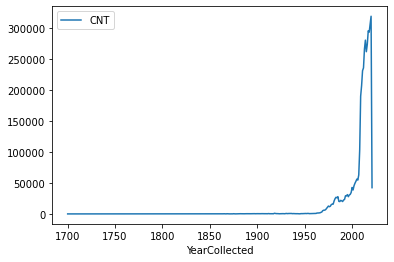

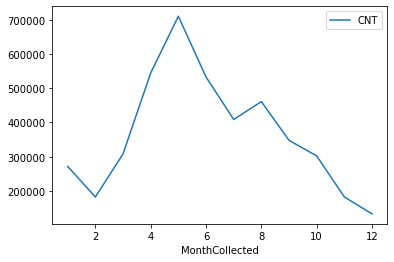

In [35]:
# Check how the observation data is skeewed

# Register Redlisted Species DataFrame as a SQL temporary view
redlist.createOrReplaceTempView("redlist")

# Count observations per year identified
YearCollected_skeew = spark.sql("""

    SELECT CAST(YearCollected AS INT) AS YearCollected, 
           COUNT(*) AS CNT 
    FROM REDLIST
    GROUP BY YearCollected
    ORDER BY CAST(YearCollected AS INT) ASC

""").toPandas()

# plot year_identified_skeew
YearCollected_skeew.plot(x="YearCollected", y="CNT")

# Count observations per month identified
MonthCollected_skeew = spark.sql("""

    SELECT CAST(MonthCollected AS INT) as MonthCollected, 
           COUNT(*) AS CNT 
    FROM REDLIST
    GROUP BY MonthCollected
    ORDER BY CAST(MonthCollected AS INT) ASC
    
""").toPandas()

# plot month_identified_skeew
MonthCollected_skeew.plot(x="MonthCollected", y="CNT")

#### Findings 
- All data in my CSV file were stored as string type
- `YearIdentified` is heavily skeewed around year 2000 and forward
- `MonthIdentified` indicates a seasonal data set with peaks in May, June, July and August. The number of observations differs around 5 million which is quite a lot considering this particular dataset.

In [27]:
# Explore Weather Station Meta data from MET Norway API

In [28]:
# Convert to data frame
weather_station_df = pd.DataFrame(weather_station_data_api)
weather_station_df.head()

,@type,id,name,shortName,country,countryCode,geometry,masl,validFrom,county,countyId,municipality,municipalityId,stationHolders,externalIds,wigosId,wmoId,icaoCodes,shipCodes
0,SensorSystem,SN47230,ÅKRA UNGDOMSSKOLE,Åkra,Norge,NO,"{'@type': 'Point', 'coordinates': [5.1963, 59....",18.0,2013-10-29T00:00:00.000Z,ROGALAND,11.0,KARMØY,1149.0,[KARMØY KOMMUNE],[506131077],0-578-0-47230,NaN,NaN,NaN
1,SensorSystem,SN23670,E16 RYFOSS,E16 Ryfoss,Norge,NO,"{'@type': 'Point', 'coordinates': [8.8175, 61....",406.0,2018-01-23T00:00:00.000Z,INNLANDET,34.0,VANG,3454.0,[STATENS VEGVESEN],"[1755, 3000021]",0-578-0-23670,NaN,NaN,NaN
2,SensorSystem,SN59450,STADLANDET,Stadlandet,Norge,NO,"{'@type': 'Point', 'coordinates': [5.2115, 62....",75.0,1923-01-01T00:00:00.000Z,VESTLAND,46.0,STAD,4649.0,[MET.NO],[10.249.1.80],0-578-0-59450,NaN,NaN,NaN
3,SensorSystem,SN12590,E6 MJØSBRUA,E6 Mjøsbrua,Norge,NO,"{'@type': 'Point', 'coordinates': [10.6725, 60...",128.0,2011-01-01T00:00:00.000Z,INNLANDET,34.0,RINGSAKER,3411.0,[STATENS VEGVESEN],"[149, 429003]",0-578-0-12590,NaN,NaN,NaN
4,SensorSystem,SN26640,E134 DARBU,E134 Darbu,Norge,NO,"{'@type': 'Point', 'coordinates': [9.7773, 59....",155.0,2016-04-19T00:00:00.000Z,VIKEN,30.0,ØVRE EIKER,3048.0,[STATENS VEGVESEN],"[1645, 629024]",0-578-0-26640,NaN,NaN,NaN


In [29]:
weather_station_df.count()

@type             1319
id                1319
name              1319
shortName         1318
country           1319
countryCode       1319
geometry          1305
masl              1292
validFrom         1319
county            1311
countyId          1318
municipality      1318
municipalityId    1318
stationHolders    1319
externalIds        982
wigosId           1318
wmoId              273
icaoCodes           72
shipCodes           49
dtype: int64

#### Findings
- The Geometry column is a nested json string
- The date fields are in special formats

#### Cleaning Steps
Document steps necessary to clean the data

In [30]:
# Fix the Redlisted species Schema
redlistSchema = R([
        Fld("FID", Int()), 
        Fld("ProxyId", Str()),
        Fld("NodeDatabaseID", Int()), 
        Fld("InstitutionCode", Str()), 
        Fld("CollectionCode", Str()), 
        Fld("CatalogNumber", Str()), 
        Fld("VitNavn", Str()),
        Fld("BasisOfRecord", Str()), 
        Fld("Kingdom", Str()), 
        Fld("Phylum", Str()), 
        Fld("Class", Str()), 
        Fld("Order", Str()), 
        Fld("Family", Str()), 
        Fld("Genus", Str()), 
        Fld("Species", Str()), 
        Fld("Subspecies", Str()), 
        Fld("Author", Str()), 
        Fld("IdentifiedBy", Str()), 
        Fld("YearIdentified", Int()), 
        Fld("MonthIdentified", Int()), 
        Fld("DayIdentified", Int()), 
        Fld("TypeStatus", Str()), 
        Fld("CollectorNumber", Str()), 
        Fld("FieldNumber", Str()), 
        Fld("Collector", Str()), 
        Fld("YearCollected", Int()),
        Fld("MonthCollected", Int()), 
        Fld("DayCollected", Int()), 
        Fld("ContinentOcean", Str()), 
        Fld("Country", Str()), 
        Fld("StateProvince", Str()), 
        Fld("CountyOrg", Str()), 
        Fld("Locality", Str()), 
        Fld("CountyID", Str()), 
        Fld("MunicipalityID", Str()), 
        Fld("County", Str()), 
        Fld("MuniName", Str()), 
        Fld("Longitude", Dbl()), 
        Fld("Latitude", Dbl()), 
        Fld("CoordinatePrecision", Int()), 
        Fld("BoundingBox", Str()), 
        Fld("MinElevation", Int()), 
        Fld("MaxElevation", Int()), 
        Fld("MinDepth", Str()), 
        Fld("MaxDepth", Str()), 
        Fld("Sex", Str()), 
        Fld("PreparationType", Str()), 
        Fld("IndividualCount", Str()), 
        Fld("PreviousCatalogNumber", Str()), 
        Fld("RelationshipType", Str()), 
        Fld("RelatedCatalogItem", Str()), 
        Fld("Notes", Str()), 
        Fld("CollectingMethod", Str()), 
        Fld("IdentificationPrecision", Int()), 
        Fld("NorskNavn", Str()), 
        Fld("Okologi", Str()), 
        Fld("Habitat", Str()),
        Fld("Substrat", Str()), 
        Fld("UTMost", Int()), 
        Fld("UTMnord", Int()), 
        Fld("UTMsone", Str()), 
        Fld("MGRSfra", Str()), 
        Fld("MGRStil", Str()), 
        Fld("UTM33ost", Int()), 
        Fld("UTM33nord", Int()), 
        Fld("KoordKilde", Str()), 
        Fld("ElevationKilde", Str()), 
        Fld("Status", Str()), 
        Fld("RelativeAboundance", Str()), 
        Fld("Antropokor", Int()), 
        Fld("URL", Str()), 
        Fld("ArtsGruppe", Int()), 
        Fld("IName", Str()), 
        Fld("CName", Str()), 
        Fld("CategoryId", Int())
])

# Read file back into memory with fixed schema
RedlistSparkDfWithFixedSchema = spark.read.csv(out_path, schema=redlistSchema, header=True)

RedlistSparkDfWithFixedSchema.printSchema()

root
 |-- FID: integer (nullable = true)
 |-- ProxyId: string (nullable = true)
 |-- NodeDatabaseID: integer (nullable = true)
 |-- InstitutionCode: string (nullable = true)
 |-- CollectionCode: string (nullable = true)
 |-- CatalogNumber: string (nullable = true)
 |-- VitNavn: string (nullable = true)
 |-- BasisOfRecord: string (nullable = true)
 |-- Kingdom: string (nullable = true)
 |-- Phylum: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Order: string (nullable = true)
 |-- Family: string (nullable = true)
 |-- Genus: string (nullable = true)
 |-- Species: string (nullable = true)
 |-- Subspecies: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- IdentifiedBy: string (nullable = true)
 |-- YearIdentified: integer (nullable = true)
 |-- MonthIdentified: integer (nullable = true)
 |-- DayIdentified: integer (nullable = true)
 |-- TypeStatus: string (nullable = true)
 |-- CollectorNumber: string (nullable = true)
 |-- FieldNumber: string (nullab

In [31]:
# Flatten out the nested column "geometry" in the weather metadata
df = pd.json_normalize(weather_station_data_api)

# Convert to Data Frame
df = pd.DataFrame(df)

# Keep these columns
columns = ['id','name','shortName','geometry.coordinates', 'validFrom', 'county','municipality']
df2 = df[columns].copy()

# Convert the validFrom field value to datetime format
df2['validFrom'] = pd.to_datetime(df2['validFrom'])

In [32]:
# Set filename
file_name_weather = "weather_station_metadata.csv"

In [33]:
# Write the result to csv
df2.to_csv(os.path.abspath(file_name_weather), encoding='UTF-8')

In [34]:
# Read weather station meta data into memory using PySpark
weather_metadata_spark_df = spark.read.csv(os.path.abspath(file_name_weather), header=True, encoding = 'UTF-8')

In [36]:
# Rename nested column name 
weatherStatioMetaDataDf = weather_metadata_spark_df.withColumnRenamed("geometry.coordinates","coordinates")

In [37]:
weatherStatioMetaDataDf.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- shortName: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- validFrom: string (nullable = true)
 |-- county: string (nullable = true)
 |-- municipality: string (nullable = true)



In [38]:
weatherStatioMetaDataDf.show(5)

+---+-------+-----------------+-----------+-----------------+--------------------+---------+------------+
|_c0|     id|             name|  shortName|      coordinates|           validFrom|   county|municipality|
+---+-------+-----------------+-----------+-----------------+--------------------+---------+------------+
|  0|SN47230|ÅKRA UNGDOMSSKOLE|      Åkra |[5.1963, 59.2555]|2013-10-29 00:00:...| ROGALAND|      KARMØY|
|  1|SN23670|       E16 RYFOSS| E16 Ryfoss|[8.8175, 61.1375]|2018-01-23 00:00:...|INNLANDET|        VANG|
|  2|SN59450|       STADLANDET| Stadlandet|[5.2115, 62.1467]|1923-01-01 00:00:...| VESTLAND|        STAD|
|  3|SN12590|      E6 MJØSBRUA|E6 Mjøsbrua|[10.6725, 60.928]|2011-01-01 00:00:...|INNLANDET|   RINGSAKER|
|  4|SN26640|       E134 DARBU| E134 Darbu|[9.7773, 59.7025]|2016-04-19 00:00:...|    VIKEN|  ØVRE EIKER|
+---+-------+-----------------+-----------+-----------------+--------------------+---------+------------+
only showing top 5 rows



In [39]:
weatherStatioMetaDataDf.count()

1319

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
The data model is a dimensional model consisting of one fact table having one row for each observation. The 6 dimension tables holds detailed information about every observation. I chose a dimensional data model because having facts and dimension helps users conceptually understand the data model and write simple queries and do fast aggregations.

- <strong>`Redlist.csv`</strong> file populates:
    - `fact_observation`
        - information about every redlisted species observation that has happened
    - `dim_status`
        - detailed information about the different redlist statuses <br>
    - `dim_location`
        - detailed information about all unique observation locations <br>
    - `dim_species`
        - detailed information about every species observed <br>
    - `dim_collected_date`
        - what date the observation were collected <br>
    - `dim_identified_date`
        - what date the observation were identified <br>
    
- <strong>`weather_station_metadata.csv`</strong> populates: <br>
    - `dim_weather_station`
        - nearby weather stations to the observation point

#### Star schema
<img src="StarSchema.png" alt="starschema" width="1000" height="700">

#### 3.2 Mapping Out Data Pipelines
1. Register all source data as temporary SQL views in PySpark
2. Use Spark SQL to extract data, cast to correct data types and create unique ID's
3. Use PySpark to write the result as parquet hosted on S3

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [55]:
# output_data = "C:/Users/aleks/dwh/redlistedSpecies/"
output_data = "s3a://aletje/dwh/redlistedSpecies"

# Register Weather Stations DataFrame as a SQL temporary view
weatherStatioMetaDataDf.createOrReplaceTempView("weather_stations")

# Register Redlisted Species DataFrame as a SQL temporary view
RedlistSparkDfWithFixedSchema.createOrReplaceTempView("redlist")

In [56]:
# extract data and perform necessary formating on Weather Stations table
weatherStatioMetaDataCleanedDf = spark.sql("""

-- Clean up and cast to correct data types
SELECT ID,
       STATIONS.NAME,
       STATIONS.SHORTNAME,
       CAST(REPLACE(STATIONS.LAT, '[', '') AS DOUBLE) AS LAT,
       CAST(REPLACE(STATIONS.LONG, ']', '') AS DOUBLE) AS LONG,
       TO_DATE(DATE_TRUNC('DAY', VALID_FROM), 'DD.MM.YYYY') AS VALID_FROM,
       COUNTY,
       MUNICIPALITY
FROM (
        --Fetch relevant columns, split coordinates into lat & long
        SELECT ID,
               NAME,
               SHORTNAME,
               SPLIT(COORDINATES, ',')[0] AS LAT,
               SPLIT(COORDINATES, ',')[1] AS LONG,
               VALIDFROM AS VALID_FROM,
               COUNTY,
               MUNICIPALITY
        FROM WEATHER_STATIONS ) STATIONS

""")

In [57]:
# Write cleaned data back to parquet
weatherStatioMetaDataCleanedDf.write.mode("overwrite").parquet(output_data + "dim_weather_station.parquet")

In [58]:
# Read cleaned data file back into memory
weather_stations = spark.read.parquet(output_data + "dim_weather_station.parquet")

weather_stations.printSchema()

root
 |-- ID: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- SHORTNAME: string (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LONG: double (nullable = true)
 |-- VALID_FROM: date (nullable = true)
 |-- COUNTY: string (nullable = true)
 |-- MUNICIPALITY: string (nullable = true)



In [59]:
weather_stations.show(5)

+-------+-----------------+-----------+-------+-------+----------+---------+------------+
|     ID|             NAME|  SHORTNAME|    LAT|   LONG|VALID_FROM|   COUNTY|MUNICIPALITY|
+-------+-----------------+-----------+-------+-------+----------+---------+------------+
|SN47230|ÅKRA UNGDOMSSKOLE|      Åkra | 5.1963|59.2555|2013-10-29| ROGALAND|      KARMØY|
|SN23670|       E16 RYFOSS| E16 Ryfoss| 8.8175|61.1375|2018-01-23|INNLANDET|        VANG|
|SN59450|       STADLANDET| Stadlandet| 5.2115|62.1467|1923-01-01| VESTLAND|        STAD|
|SN12590|      E6 MJØSBRUA|E6 Mjøsbrua|10.6725| 60.928|2011-01-01|INNLANDET|   RINGSAKER|
|SN26640|       E134 DARBU| E134 Darbu| 9.7773|59.7025|2016-04-19|    VIKEN|  ØVRE EIKER|
+-------+-----------------+-----------+-------+-------+----------+---------+------------+
only showing top 5 rows



In [60]:
weather_stations.count()

1319

In [233]:
# extract columns to create species dimension table
dim_species = spark.sql("""
SELECT ROW_NUMBER() OVER(ORDER BY KINGDOM, PHYLUM, CLASS, ORDER, FAMILY, GENUS, SPECIES ASC) AS SPECIES_KEY,
       REDLISTED_SPECIES.*
FROM (
-- Fetch all unique redlisted species in Norway
    SELECT DISTINCT
            KINGDOM,
            PHYLUM,
            CLASS,
            ORDER,
            FAMILY,
            GENUS,
            SPECIES,
            SUBSPECIES,
            AUTHOR,
            NORSKNAVN AS NORWEGIAN_NAME
    FROM REDLIST ) REDLISTED_SPECIES
""")

In [234]:
dim_species.printSchema()

root
 |-- SPECIES_KEY: integer (nullable = true)
 |-- KINGDOM: string (nullable = true)
 |-- PHYLUM: string (nullable = true)
 |-- CLASS: string (nullable = true)
 |-- ORDER: string (nullable = true)
 |-- FAMILY: string (nullable = true)
 |-- GENUS: string (nullable = true)
 |-- SPECIES: string (nullable = true)
 |-- SUBSPECIES: string (nullable = true)
 |-- AUTHOR: string (nullable = true)
 |-- NORWEGIAN_NAME: string (nullable = true)



In [235]:
dim_species.show(5)

+-----------+--------+--------+----------+----------------+---------------+------------+--------------------+----------+------------------+-----------------+
|SPECIES_KEY| KINGDOM|  PHYLUM|     CLASS|           ORDER|         FAMILY|       GENUS|             SPECIES|SUBSPECIES|            AUTHOR|   NORWEGIAN_NAME|
+-----------+--------+--------+----------+----------------+---------------+------------+--------------------+----------+------------------+-----------------+
|          1|Animalia|Annelida|Clitellata|Arhynchobdellida|  Erpobdellidae|  Erpobdella| Erpobdella testacea|      null|   (Savigny, 1820)|  liten hundeigle|
|          2|Animalia|Annelida|Clitellata|Arhynchobdellida|    Hirudinidae|      Hirudo|  Hirudo medicinalis|      null|    Linnaeus, 1758|         blodigle|
|          3|Animalia|Annelida|Clitellata| Rhynchobdellida|Glossiphoniidae|Glossiphonia|Glossiphonia conc...|      null|    (Apáthy, 1888)|gråbrun bruskigle|
|          4|Animalia|Annelida|Clitellata| Rhynchobd

In [236]:
dim_species.count()

4249

In [237]:
# write species table back to S3
dim_species.write.mode("overwrite").parquet(output_data + "dim_species.parquet")

In [134]:
# extract columns to create redlist status dimension table
dim_status = spark.sql("""
SELECT ROW_NUMBER() OVER(ORDER BY STATUS.STATUS ASC) AS STATUS_KEY,
       STATUS.*
FROM (
        -- Fetch all unique redlist status' (https://en.wikipedia.org/wiki/IUCN_Red_List)
        SELECT DISTINCT
                R.STATUS,
                CASE
                -- Versjon 3.1 IUCN (2001)
                WHEN UPPER(R.STATUS) = 'EX' THEN 'Extinct'
                WHEN UPPER(R.STATUS) = 'EW' THEN 'Extinct in the wild'
                WHEN UPPER(R.STATUS) = 'CR' THEN 'Critically Endangered'
                WHEN UPPER(R.STATUS) = 'EN' THEN 'Endangered'
                WHEN UPPER(R.STATUS) = 'VU' THEN 'Vulnerable'
                WHEN UPPER(R.STATUS) = 'NT' THEN 'Near Threatened'
                WHEN UPPER(R.STATUS) = 'LC' THEN 'Least concern'
                WHEN UPPER(R.STATUS) = 'DD' THEN 'Data deficient'
                WHEN UPPER(R.STATUS) = 'NE' THEN 'Not evaluated'
                -- Versjon 2.3 IUCN (1994)
                WHEN UPPER(R.STATUS) = 'LR' THEN 'Lower risk'
                WHEN UPPER(R.STATUS) = 'LR/CD' THEN 'Lower risk/Conservation Dependent'
                WHEN UPPER(R.STATUS) = 'LR/NT' THEN 'Lower risk/Near Threatened'
                WHEN UPPER(R.STATUS) = 'LR/LC' THEN 'Lower risk/Least Concern'
                ELSE 'n/a'
                END DESCRIPTION
        FROM REDLIST R) STATUS
""")

In [135]:
dim_status.printSchema()

root
 |-- STATUS_KEY: integer (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- DESCRIPTION: string (nullable = false)



In [136]:
dim_status.show()

+----------+------+--------------------+
|STATUS_KEY|STATUS|         DESCRIPTION|
+----------+------+--------------------+
|         1|    CR|Critically Endang...|
|         2|    DD|      Data deficient|
|         3|    EN|          Endangered|
|         4|    NT|     Near Threatened|
|         5|    RE|                 n/a|
|         6|    VU|          Vulnerable|
+----------+------+--------------------+



In [137]:
dim_status.write.mode("overwrite").parquet(output_data + "dim_status.parquet")

In [138]:
# extract columns to create species location dimension table
# join weather_stations to fetch the nearby weather stations

dim_location = spark.sql("""

SELECT ROW_NUMBER() OVER(ORDER BY LOCALITY, LATITUDE, LONGITUDE ASC) AS LOCATION_KEY,
       REDLISTED_SPECIE_LOCATION.*
FROM (
    -- Fetch all unique locations of observed redlisted species in Norway
        SELECT DISTINCT
                R.LOCALITY,
                CAST(R.LATITUDE AS DOUBLE) AS LATITUDE,
                CAST(R.LONGITUDE AS DOUBLE) AS LONGITUDE,
                UPPER(R.COUNTRY) AS COUNTRY,
                UPPER(R.COUNTY) AS COUNTY,
                UPPER(R.MUNINAME) AS MUNINAME,
                R.COORDINATEPRECISION,
                R.CONTINENTOCEAN,
                R.STATEPROVINCE,
                R.COUNTYORG
        FROM REDLIST R
    ) REDLISTED_SPECIE_LOCATION

""")

In [139]:
dim_location.printSchema()

root
 |-- LOCATION_KEY: integer (nullable = true)
 |-- LOCALITY: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- COUNTY: string (nullable = true)
 |-- MUNINAME: string (nullable = true)
 |-- COORDINATEPRECISION: integer (nullable = true)
 |-- CONTINENTOCEAN: string (nullable = true)
 |-- STATEPROVINCE: string (nullable = true)
 |-- COUNTYORG: string (nullable = true)



In [140]:
dim_location.show(5)

+------------+--------+---------+---------+-------+------------------+--------+-------------------+--------------+-------------+---------+
|LOCATION_KEY|LOCALITY| LATITUDE|LONGITUDE|COUNTRY|            COUNTY|MUNINAME|COORDINATEPRECISION|CONTINENTOCEAN|STATEPROVINCE|COUNTYORG|
+------------+--------+---------+---------+-------+------------------+--------+-------------------+--------------+-------------+---------+
|           1|    null|56.246666|    3.455| NORWAY|NORSKEKYSTEN HAV S|    null|                 50|          null|         null|     null|
|           2|    null|   56.285| 3.666667| NORWAY|NORSKEKYSTEN HAV S|    null|                 50|          null|         null|     null|
|           3|    null|56.386665| 2.926667| NORWAY|NORSKEKYSTEN HAV S|    null|                 50|          null|         null|     null|
|           4|    null|56.406666| 3.713333| NORWAY|NORSKEKYSTEN HAV S|    null|                 50|          null|         null|     null|
|           5|    null|56.6

In [226]:
dim_location.count()

606603

In [142]:
# write locations table back to S3, repartition by 8 / cores availiable on my machine
dim_location.repartition(8).write.mode("overwrite").parquet(output_data + "dim_location.parquet")

In [143]:
# extract columns to create species date collected dimension table
dim_collected_date = spark.sql("""
SELECT ROW_NUMBER() OVER(ORDER BY YEARCOLLECTED, MONTHCOLLECTED, DAYCOLLECTED ASC) AS DATE_COLLECTED_KEY,
       DATE_COLLECTED.*
FROM (
-- Fetch all unique collection dates
    SELECT DISTINCT
            YEARCOLLECTED,
            MONTHCOLLECTED,
            DAYCOLLECTED
    FROM REDLIST ) DATE_COLLECTED
""")

In [144]:
dim_collected_date.printSchema()

root
 |-- DATE_COLLECTED_KEY: integer (nullable = true)
 |-- YEARCOLLECTED: integer (nullable = true)
 |-- MONTHCOLLECTED: integer (nullable = true)
 |-- DAYCOLLECTED: integer (nullable = true)



In [145]:
dim_collected_date.show(5)

+------------------+-------------+--------------+------------+
|DATE_COLLECTED_KEY|YEARCOLLECTED|MONTHCOLLECTED|DAYCOLLECTED|
+------------------+-------------+--------------+------------+
|                 1|         1700|             1|           1|
|                 2|         1701|             1|           1|
|                 3|         1707|             1|           1|
|                 4|         1710|             1|           1|
|                 5|         1715|             5|           1|
+------------------+-------------+--------------+------------+
only showing top 5 rows



In [146]:
dim_collected_date.count()

30392

In [147]:
# write collected dates table back to S3
dim_collected_date.write.mode("overwrite").parquet(output_data + "dim_collected_date.parquet")

In [148]:
# extract columns to create species date identified dimension table
dim_identified_date = spark.sql("""
SELECT ROW_NUMBER() OVER(ORDER BY YEARIDENTIFIED, MONTHIDENTIFIED, DAYIDENTIFIED ASC) AS DATE_IDENTIFIED_KEY,
       DATE_IDENTIFIED.*
FROM (
-- Fetch all unique species date identified
    SELECT DISTINCT
            YEARIDENTIFIED,
            MONTHIDENTIFIED,
            DAYIDENTIFIED
    FROM REDLIST ) DATE_IDENTIFIED
""")

In [149]:
dim_identified_date.printSchema()

root
 |-- DATE_IDENTIFIED_KEY: integer (nullable = true)
 |-- YEARIDENTIFIED: integer (nullable = true)
 |-- MONTHIDENTIFIED: integer (nullable = true)
 |-- DAYIDENTIFIED: integer (nullable = true)



In [150]:
dim_identified_date.show(5)

+-------------------+--------------+---------------+-------------+
|DATE_IDENTIFIED_KEY|YEARIDENTIFIED|MONTHIDENTIFIED|DAYIDENTIFIED|
+-------------------+--------------+---------------+-------------+
|                  1|             0|              0|            0|
|                  2|          1700|              1|            1|
|                  3|          1701|              1|            1|
|                  4|          1707|              1|            1|
|                  5|          1710|              1|            1|
+-------------------+--------------+---------------+-------------+
only showing top 5 rows



In [151]:
dim_identified_date.count()

17420

In [152]:
# write identified dates table back to S3
dim_identified_date.write.mode("overwrite").parquet(output_data + "dim_identified_date.parquet")

In [24]:
# Read in parquet files back into memory and Create temporary views
spark.read.parquet(output_data + "dim_species.parquet").createOrReplaceTempView("species")
spark.read.parquet(output_data + "dim_location.parquet").createOrReplaceTempView("location")
spark.read.parquet(output_data + "dim_collected_date.parquet").createOrReplaceTempView("collected_date")
spark.read.parquet(output_data + "dim_identified_date.parquet").createOrReplaceTempView("identified_date")
spark.read.parquet(output_data + "dim_status.parquet").createOrReplaceTempView("status")

# extract columns to create species observation fact table
# join temporary views and substitute relevant fields with their keys
fact_observation = spark.sql("""
SELECT ROW_NUMBER() OVER(ORDER BY OBSERVATIONS.FID ASC) AS OBSERVATION_KEY,
       OBSERVATIONS.SPECIES_KEY,
       OBSERVATIONS.LOCATION_KEY,
       OBSERVATIONS.STATUS_KEY,
       OBSERVATIONS.DATE_COLLECTED_KEY,
       OBSERVATIONS.DATE_IDENTIFIED_KEY,
       OBSERVATIONS.IDENTIFIEDBY,
       OBSERVATIONS.COLLECTOR,
       OBSERVATIONS.INDIVIDUALCOUNT,
       OBSERVATIONS.NOTES,
       OBSERVATIONS.COLLECTINGMETHOD,
       OBSERVATIONS.OKOLOGI,
       OBSERVATIONS.HABITAT,
       OBSERVATIONS.INAME,
       OBSERVATIONS.CNAME
FROM (
        SELECT  R.FID,
                S.SPECIES_KEY,
                STATUS.STATUS_KEY,
                L.LOCATION_KEY,
                CD.DATE_COLLECTED_KEY,
                ID.DATE_IDENTIFIED_KEY,
                R.IDENTIFIEDBY,
                R.COLLECTOR,
                R.INDIVIDUALCOUNT,
                R.NOTES,
                R.COLLECTINGMETHOD,
                R.OKOLOGI,
                R.HABITAT,
                R.INAME,
                R.CNAME
        FROM REDLIST R
        LEFT JOIN SPECIES S  ON S.KINGDOM    = R.KINGDOM
                            AND S.PHYLUM     = R.PHYLUM
                            AND S.CLASS      = R.CLASS
                            AND S.ORDER      = R.ORDER
                            AND S.FAMILY     = R.FAMILY
                            AND S.GENUS      = R.GENUS
                            AND S.SPECIES    = R.SPECIES
                            AND S.SUBSPECIES = R.SUBSPECIES
                            AND S.AUTHOR     = R.AUTHOR
                            
        LEFT JOIN LOCATION L ON L.LONGITUDE  = CAST(R.LONGITUDE AS DOUBLE)
                            AND L.LATITUDE   = CAST(R.LATITUDE AS DOUBLE)
                            AND L.LOCALITY   = R.LOCALITY
                            AND L.MUNINAME   = UPPER(R.MUNINAME)
                            AND L.COUNTY     = UPPER(R.COUNTY)
                            AND L.COORDINATEPRECISION = R.COORDINATEPRECISION
        
        LEFT JOIN STATUS ON STATUS.STATUS = UPPER(R.STATUS)
                            
        LEFT JOIN COLLECTED_DATE CD  ON CD.YEARCOLLECTED   = R.YEARCOLLECTED
                                    AND CD.MONTHCOLLECTED  = R.MONTHCOLLECTED
                                    AND CD.DAYCOLLECTED    = R.DAYCOLLECTED
                                    
        LEFT JOIN IDENTIFIED_DATE ID ON ID.YEARIDENTIFIED  = R.YEARIDENTIFIED
                                    AND ID.MONTHIDENTIFIED = R.MONTHIDENTIFIED
                                    AND ID.DAYIDENTIFIED   = R.DAYIDENTIFIED
                                    
                                ) OBSERVATIONS
""")

In [25]:
fact_observation.printSchema()

root
 |-- OBSERVATION_KEY: integer (nullable = true)
 |-- SPECIES_KEY: integer (nullable = true)
 |-- LOCATION_KEY: integer (nullable = true)
 |-- STATUS_KEY: integer (nullable = true)
 |-- DATE_COLLECTED_KEY: integer (nullable = true)
 |-- DATE_IDENTIFIED_KEY: integer (nullable = true)
 |-- IDENTIFIEDBY: string (nullable = true)
 |-- COLLECTOR: string (nullable = true)
 |-- INDIVIDUALCOUNT: string (nullable = true)
 |-- NOTES: string (nullable = true)
 |-- COLLECTINGMETHOD: string (nullable = true)
 |-- OKOLOGI: string (nullable = true)
 |-- HABITAT: string (nullable = true)
 |-- INAME: string (nullable = true)
 |-- CNAME: string (nullable = true)



In [216]:
fact_observation.count()

4384290

In [240]:
fact_observation.show(5)

+---------------+-----------+------------+----------+------------------+-------------------+--------------+-----------+---------------+-----------+----------------+-------+--------------------+--------------------+--------------------+
|OBSERVATION_KEY|SPECIES_KEY|LOCATION_KEY|STATUS_KEY|DATE_COLLECTED_KEY|DATE_IDENTIFIED_KEY|  IDENTIFIEDBY|  COLLECTOR|INDIVIDUALCOUNT|      NOTES|COLLECTINGMETHOD|OKOLOGI|             HABITAT|               INAME|               CNAME|
+---------------+-----------+------------+----------+------------------+-------------------+--------------+-----------+---------------+-----------+----------------+-------+--------------------+--------------------+--------------------+
|              1|       null|       20801|         4|             18447|               8350|     R. Haugan|  R. Haugan|           null|       null|            null|   null|On S side of larg...|Naturhistorisk Mu...|l hos Naturhistor...|
|              2|       null|      201478|         6|   

In [241]:
# write observations table back to S3, repartition by 8 - cores availiable on my machine
fact_observation.repartition(8).write.mode("overwrite").parquet(output_data + "fact_observation.parquet")

#### 4.2 Data Quality Checks
1. Check if it exists records in source table which are not available in the fact table
2. Perform an analytical query and verify that results are the same in our source table
 
Run Quality Checks

In [61]:
# Read parquet files from S3
observations    = spark.read.parquet(output_data + "fact_observation.parquet")
species         = spark.read.parquet(output_data + "dim_species.parquet")
status          = spark.read.parquet(output_data + "dim_status.parquet")
location        = spark.read.parquet(output_data + "dim_location.parquet")
collected_date  = spark.read.parquet(output_data + "dim_collected_date.parquet")
identified_date = spark.read.parquet(output_data + "dim_identified_date.parquet")
weather_station = spark.read.parquet(output_data + "dim_weather_station.parquet")

In [62]:
# Register DataFrames as a SQL temporary view

# Source table
RedlistSparkDfWithFixedSchema.createOrReplaceTempView("redlist")

# Dimensional model
observations.createOrReplaceTempView("observations")
species.createOrReplaceTempView("species")
status.createOrReplaceTempView("status")
location.createOrReplaceTempView("location")
collected_date.createOrReplaceTempView("collected_date")
identified_date.createOrReplaceTempView("identified_date")
weather_station.createOrReplaceTempView("weather_station")

In [63]:
# both source and target tables should return equal number of rows

df = spark.sql("""

--Check if it exists records in source table which are not available in the fact table

    --source
    SELECT YEARCOLLECTED,
           MONTHCOLLECTED,
           DAYCOLLECTED,
           YEARIDENTIFIED,
           MONTHIDENTIFIED,
           DAYIDENTIFIED,
           COUNT(*) AS CNT
    FROM REDLIST
    GROUP BY YEARCOLLECTED,
             MONTHCOLLECTED,
             DAYCOLLECTED,
             YEARIDENTIFIED,
             MONTHIDENTIFIED,
             DAYIDENTIFIED
               
    EXCEPT
             
    --targets
    SELECT CD.YEARCOLLECTED,
           CD.MONTHCOLLECTED,
           CD.DAYCOLLECTED,
           ID.YEARIDENTIFIED,
           ID.MONTHIDENTIFIED,
           ID.DAYIDENTIFIED,
           COUNT(*) AS CNT
    FROM OBSERVATIONS O
    LEFT JOIN COLLECTED_DATE CD ON CD.DATE_COLLECTED_KEY = O.DATE_COLLECTED_KEY
    LEFT JOIN IDENTIFIED_DATE ID ON ID.DATE_IDENTIFIED_KEY = O.DATE_IDENTIFIED_KEY
    GROUP BY   CD.YEARCOLLECTED,
               CD.MONTHCOLLECTED,
               CD.DAYCOLLECTED,
               ID.YEARIDENTIFIED,
               ID.MONTHIDENTIFIED,
               ID.DAYIDENTIFIED
    
""").show()

+-------------+--------------+------------+--------------+---------------+-------------+---+
|YEARCOLLECTED|MONTHCOLLECTED|DAYCOLLECTED|YEARIDENTIFIED|MONTHIDENTIFIED|DAYIDENTIFIED|CNT|
+-------------+--------------+------------+--------------+---------------+-------------+---+
+-------------+--------------+------------+--------------+---------------+-------------+---+



In [246]:
# Perform an analytical query
df = spark.sql("""
    SELECT O.IDENTIFIEDBY,
           O.NOTES,
           S.KINGDOM,
           S.SPECIES,
           STATUS.DESCRIPTION,
           S.NORWEGIAN_NAME,
           CD.YEARCOLLECTED,
           CD.MONTHCOLLECTED,
           CD.DAYCOLLECTED
    FROM OBSERVATIONS O
    INNER JOIN SPECIES S ON S.SPECIES_KEY = O.SPECIES_KEY
    LEFT JOIN COLLECTED_DATE CD ON CD.DATE_COLLECTED_KEY = O.DATE_COLLECTED_KEY
    LEFT JOIN IDENTIFIED_DATE ID ON ID.DATE_IDENTIFIED_KEY = O.DATE_IDENTIFIED_KEY
    LEFT JOIN STATUS ON STATUS.STATUS_KEY = O.STATUS_KEY
    WHERE ID.YEARIDENTIFIED IN (2019, 2020, 2021)
""").toPandas()

In [247]:
# select a sample based on lookup condition
lookup = ['Coeloglossum viride']

df_plantae = df[(df['KINGDOM'] == 'Plantae') & df['SPECIES'].isin(lookup)]

In [248]:
df_plantae.head()

,IDENTIFIEDBY,NOTES,KINGDOM,SPECIES,DESCRIPTION,NORWEGIAN_NAME,YEARCOLLECTED,MONTHCOLLECTED,DAYCOLLECTED
668,"H. Hegre, R. Elven",None,Plantae,Coeloglossum viride,Endangered,islandsgrønnkurle,1986,8,31
1749,"H. Hegre, R. Elven",None,Plantae,Coeloglossum viride,Endangered,islandsgrønnkurle,1962,10,1
1846,"H. Hegre, R. Elven",None,Plantae,Coeloglossum viride,Endangered,islandsgrønnkurle,1972,9,3


In [164]:
# Check if this is true in source
df_quality_check = spark.sql("""
    SELECT IDENTIFIEDBY,
           NOTES,
           KINGDOM,
           SPECIES,
           NORSKNAVN AS NORWEGIAN_NAME,
           YEARCOLLECTED,
           MONTHCOLLECTED,
           DAYCOLLECTED
    FROM REDLIST
    WHERE SPECIES IN ('Coeloglossum viride')
      AND YEARIDENTIFIED IN (2019, 2020, 2021)
""").toPandas()

In [165]:
df_quality_check

,IDENTIFIEDBY,NOTES,KINGDOM,SPECIES,NORWEGIAN_NAME,YEARCOLLECTED,MONTHCOLLECTED,DAYCOLLECTED
0,"H. Hegre, R. Elven",None,Plantae,Coeloglossum viride,islandsgrønnkurle,1986,8,31
1,"H. Hegre, R. Elven",None,Plantae,Coeloglossum viride,islandsgrønnkurle,1962,10,1
2,"H. Hegre, R. Elven",None,Plantae,Coeloglossum viride,islandsgrønnkurle,1972,9,3


#### Result
The number of records and details are correct

#### 4.3 Data dictionary 
<a href="datadict.txt">Data dictionary</a>

#### Step 5: Project Write Up
The purpose of the project was to make a dimensional model for querying redlisted species observations. Further enrich every observation with weather station metadata close to the redlisted species observation geo-location point. The data contains redlisted species observations from year 1700 until present time. The weather station meta data could be interesting if you want to know the weather conditions back in time for that particular species observation location.

#### Tools
I use PySpark for data cleaning and ETL. Spark in local mode works fast in memory. If data were to increase, it is easy to scale out vertically to handle larger volums connecting to other machines or cloud services like AWS.

#### Overview of the steps taken in the project

- Restore Artskart2Index database using the .bak-file and a local instance of SQL Server Express
- Push down a query to SQL Server using PySpark and JDBC connector. Gather data from an existing database view fetching all redlisted species observations
- Write the result to a partitioned CSV file and copy files to S3
- Connect to MET Norway's API service and fetch weather station meta data in JSON format
- Explore and clean data using PySpark, Spark SQL and Pandas validating that all data is in the expected format
- Define the conceptual data model 
- Extract, transform and load data as parquet files into S3 using PySpark and Spark SQL
- Write data quality checks to ensure data is correct

#### Updating data
In order to keep data relevant, data should be updated whenever there is a new redlisted species observation registered in Artskart

#### The data was increased by 100x:
If data were to increase by 100x, I would add more workers to the Spark cluster speeding up load times. Since data is heavily skeweed, data must be partitioned according to the number of nodes working simultaneously.

#### The data populates a dashboard that must be updated on a daily basis by 7am every day.
If data were to populate a dashboard on a daily basis by 7am every day, I would orchestrate an ETL job in Airflow creating a DAG with a schedule interval accordingly.

#### The database needed to be accessed by 100+ people.
I would provide IAM users with read access to S3